## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

L2  : 0.0016233465555306112
Linf: 0.002205512666996423


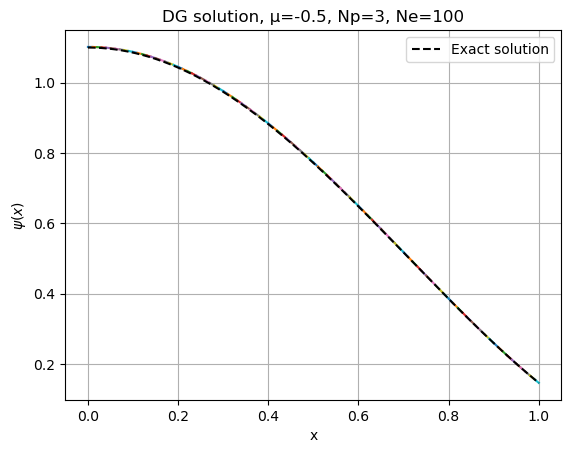

In [4]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = -0.5
ψ_MMS   = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)) # Manufactures solution
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: ψ_MMS(x)

# Mesh parameters
xs = np.linspace(0, 1, 101) # Mesh points / element boundaries
Np = 3                      # Legendre polynomials per element (basis size)

# Solve
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)

# Print the error in the solution
print("L2  :",error_Lp(ψ_weights, xs, Np, ψ_MMS, p=2))
print("Linf:",error_Lp(ψ_weights, xs, Np, ψ_MMS, p='inf'))

# Plot numerical solution against the exact solution (MMS)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

In [16]:
ψ_weights.reshape((3,100)).shape

(3, 100)